In [7]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')
import html
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,accuracy_score,precision_score,recall_score,f1_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [8]:
# importing the dataset
data = pd.read_excel("drugsCom_raw.xlsx",sheet_name="drugsCom_raw")
data

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,2012-05-20,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,2010-04-27,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,2009-12-14,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,2015-11-03,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,2016-11-27,37
...,...,...,...,...,...,...,...
161292,191035,Campral,Alcohol Dependence,"""I wrote my first report in Mid-October of 201...",10,2015-05-31,125
161293,127085,Metoclopramide,Nausea/Vomiting,"""I was given this in IV before surgey. I immed...",1,2011-11-01,34
161294,187382,Orencia,Rheumatoid Arthritis,"""Limited improvement after 4 months, developed...",2,2014-03-15,35
161295,47128,Thyroid desiccated,Underactive Thyroid,"""I&#039;ve been on thyroid medication 49 years...",10,2015-09-19,79


In [9]:
# dropping the unnamed 
# the required conditions to keep
req_conditions = ["Depression", "High Blood Pressure", "Diabetes, Type 2"]
# Filtering the DataFrame to only keep the records with the specified conditions
data = data[data['condition'].isin(req_conditions)]
data.drop(['Unnamed: 0'],axis =1,inplace=True)
data.drop(['date'],axis=1,inplace=True)
data.reset_index(drop=True,inplace=True)
data.head()

,drugName,condition,review,rating,usefulCount
0,L-methylfolate,Depression,"""I have taken anti-depressants for years, with...",10,54
1,Sertraline,Depression,"""1 week on Zoloft for anxiety and mood swings....",8,3
2,Venlafaxine,Depression,"""my gp started me on Venlafaxine yesterday to ...",4,3
3,Dulaglutide,"Diabetes, Type 2","""Hey Guys, It&#039;s been 4 months since my l...",10,24
4,Effexor XR,Depression,"""This medicine saved my life. I was at my wits...",10,166


In [10]:
# EDA
data.shape

(13944, 5)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13944 entries, 0 to 13943
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   drugName     13944 non-null  object
 1   condition    13944 non-null  object
 2   review       13944 non-null  object
 3   rating       13944 non-null  int64 
 4   usefulCount  13944 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 544.8+ KB


In [12]:
# checking for null values
data.isnull().sum()

drugName       0
condition      0
review         0
rating         0
usefulCount    0
dtype: int64

In [13]:
# checking duplicated rows
data[data.duplicated()]

,drugName,condition,review,rating,usefulCount


In [14]:
# checking duplicated columns
data.columns[data.columns.duplicated()]

Index([], dtype='object')

In [15]:
# dislaying top 10 drugs with highest no of reviews
data['drugName'].value_counts().nlargest(10)

drugName
Bupropion         549
Sertraline        459
Venlafaxine       437
Pristiq           418
Desvenlafaxine    414
Citalopram        388
Escitalopram      380
Vortioxetine      345
Duloxetine        328
Vilazodone        315
Name: count, dtype: int64

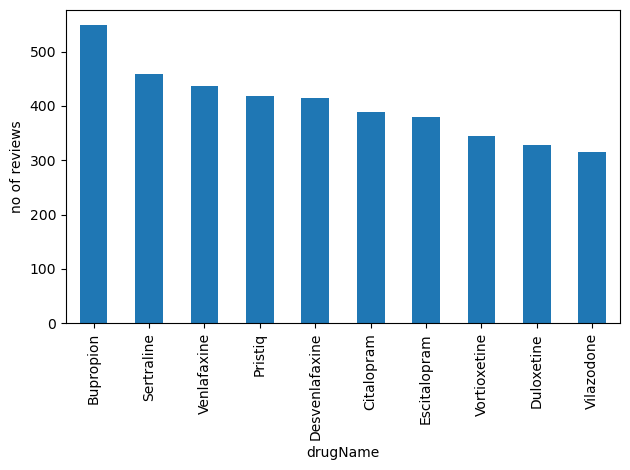

In [16]:
# visualization
# plotting the top 10 drugs with highest no of reviews
data['drugName'].value_counts().nlargest(10).plot(kind='bar')
plt.ylabel('no of reviews')
plt.tight_layout()
plt.show()

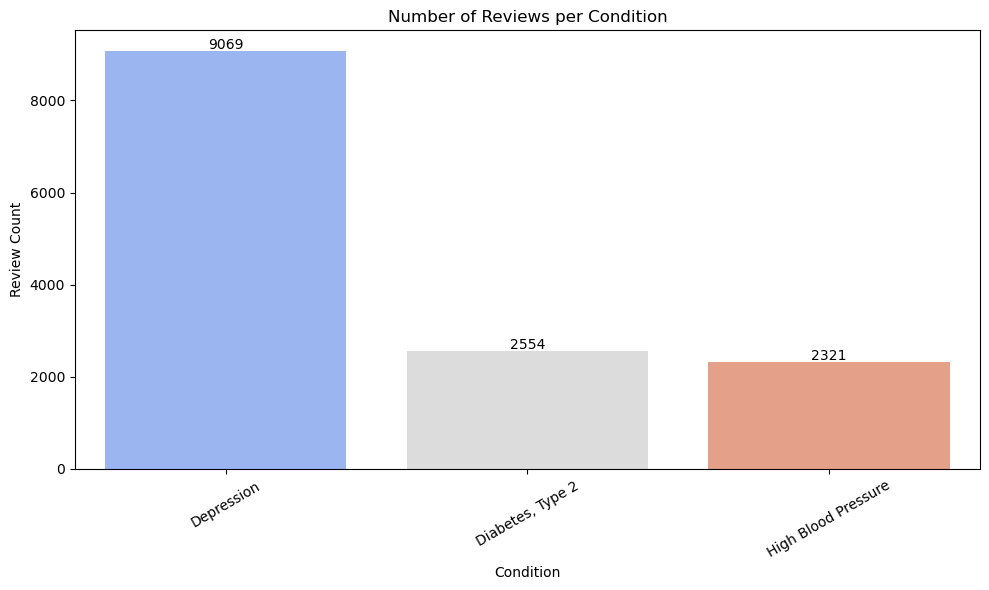

In [17]:
# Count of each condition
condition_counts = data['condition'].value_counts().reset_index()
condition_counts.columns = ['Condition', 'Count']
# Set up a single figure
plt.figure(figsize=(10, 6))
# Bar Plot
ax = sns.barplot(data=condition_counts, x='Condition', y='Count', palette='coolwarm')
# Add text labels above bars
for index, row in condition_counts.iterrows():
    ax.text(index, row['Count'] + 50, f"{row['Count']}", color='black', ha="center")
# Customize plot
plt.title('Number of Reviews per Condition')
plt.xlabel('Condition')
plt.ylabel('Review Count')
plt.xticks(rotation=30)
# Show plot
plt.tight_layout()
plt.show()

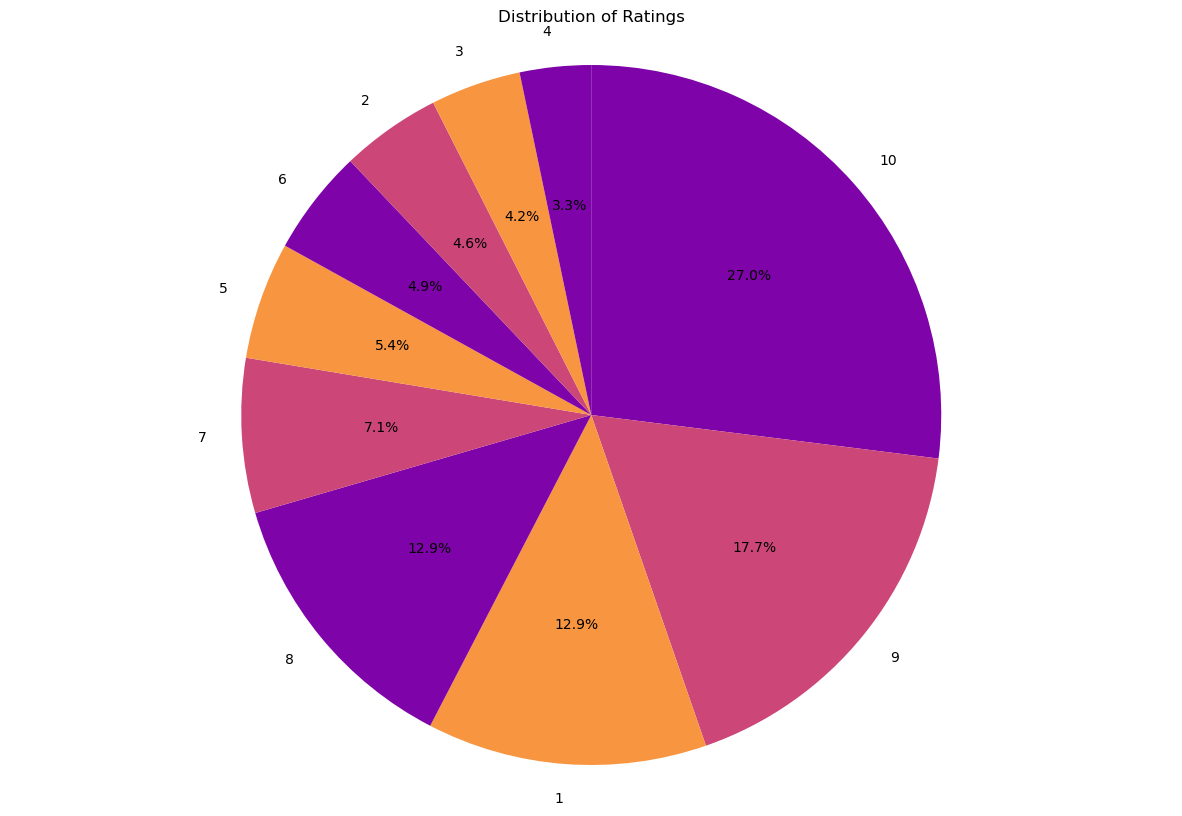

In [18]:
# Plotting a pie chart of the distribution of ratings
rating_counts = data.groupby('rating').size().reset_index(name='counts')
rating_counts = rating_counts.sort_values(by='counts',ascending=False)
plt.figure(figsize=(15,10))
plt.pie(rating_counts['counts'],labels=rating_counts['rating'],startangle=90, counterclock=False, autopct='%1.1f%%',colors=sns.color_palette('plasma', n_colors=len(condition_counts)))
plt.title('Distribution of Ratings')
plt.axis('equal')
plt.show()

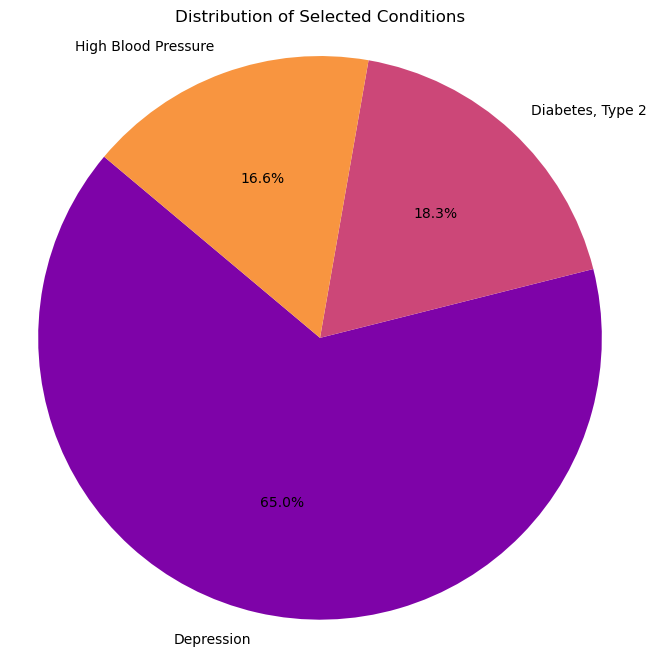

In [19]:
# to check distribution of the conditions
condition_counts = data['condition'].value_counts()
# Plotting pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    condition_counts.values, 
    labels=condition_counts.index, 
    autopct='%1.1f%%',  
    startangle=140,
    colors=sns.color_palette('plasma', n_colors=len(condition_counts))
)
plt.title('Distribution of Selected Conditions')
plt.axis('equal')  # Ensures the pie chart is circular
plt.show()

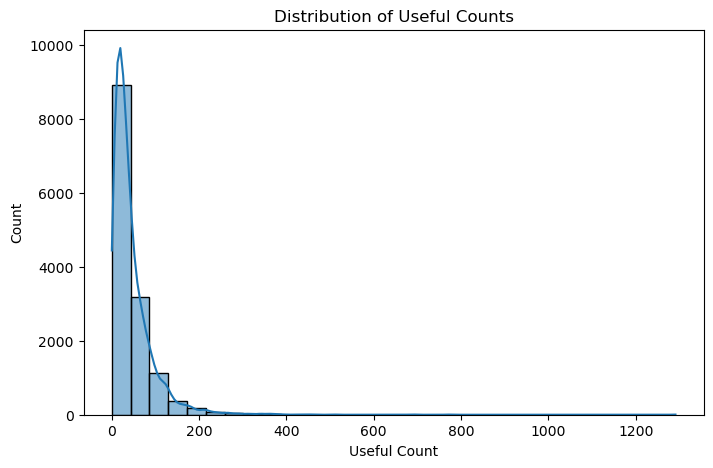

In [20]:
# plot to check distribution of useful counts
plt.figure(figsize=(8,5))
sns.histplot(data['usefulCount'], bins=30, kde=True)
plt.title("Distribution of Useful Counts")
plt.xlabel("Useful Count")
plt.ylabel("Count")
plt.show()

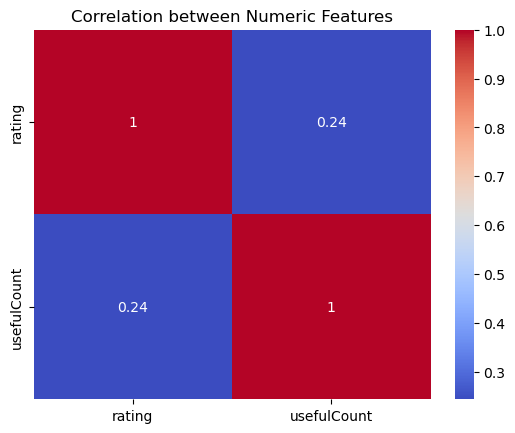

In [21]:
# checking for correlations between the variables
# Selecting numeric columns
numeric_data = data[['rating', 'usefulCount']]
# Correlation heatmap
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation between Numeric Features")
plt.show()

In [22]:
# Function to clean and preprocess the text review
def preprocess_review(text):
    # removes HTML entities like &#039; 
    text = html.unescape(text)
    # Converts all characters to lowercase
    text = text.lower()
     # Remove URLs (http, https, www)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
     # Remove newline characters
    text = re.sub(r'\n', '', text)
    # Remove unwanted characters
    text = re.sub('[\.*?/]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # removes punctuations
    text = re.sub('w*\d\w*', '', text) # Removes words containing digits
    text = re.sub(r"[\'\"“”‘’,.]", "", text)
    # Tokenization
    words = nltk.word_tokenize(text)
    # Remove stopwords
    words = [word for word in words if word not in stopwords.words('english')]
    # removes extra white spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    # Join the cleaned, lemmatized words into a single string
    cleaned_text = ' '.join(lemmatized_words)
    return cleaned_text
data['review'] = data['review'].apply(lambda x: preprocess_review(x))    

In [23]:
data

,drugName,condition,review,rating,usefulCount
0,L-methylfolate,Depression,taken antidepressant year improvement mostly m...,10,54
1,Sertraline,Depression,week zoloft anxiety mood swing take morning br...,8,3
2,Venlafaxine,Depression,gp started venlafaxine yesterday help depressi...,4,3
3,Dulaglutide,"Diabetes, Type 2",hey guy month since last post wanted give mont...,10,24
4,Effexor XR,Depression,medicine saved life wit end antidepressant rea...,10,166
...,...,...,...,...,...
13939,Metoprolol,High Blood Pressure,fourth blood pressure pill feel like partly wo...,4,39
13940,Bystolic,High Blood Pressure,bystolic foot arm numb blood sugar became seve...,1,25
13941,Invokana,"Diabetes, Type 2",got diagnosed type doctor prescribed invokana ...,9,47
13942,Vortioxetine,Depression,third med ive tried anxiety mild depression we...,2,33


In [24]:
# summary statistics 
data.describe()

,rating,usefulCount
count,13944.000000,13944.000000
mean,6.862952,45.737880
std,3.207061,51.782627
min,1.000000,0.000000
25%,4.000000,16.000000
50%,8.000000,31.000000
75%,10.000000,59.000000
max,10.000000,1291.000000


In [25]:
# encoding categorical columns
le = LabelEncoder()
data['condition'] = le.fit_transform(data['condition'])
data

,drugName,condition,review,rating,usefulCount
0,L-methylfolate,0,taken antidepressant year improvement mostly m...,10,54
1,Sertraline,0,week zoloft anxiety mood swing take morning br...,8,3
2,Venlafaxine,0,gp started venlafaxine yesterday help depressi...,4,3
3,Dulaglutide,1,hey guy month since last post wanted give mont...,10,24
4,Effexor XR,0,medicine saved life wit end antidepressant rea...,10,166
...,...,...,...,...,...
13939,Metoprolol,2,fourth blood pressure pill feel like partly wo...,4,39
13940,Bystolic,2,bystolic foot arm numb blood sugar became seve...,1,25
13941,Invokana,1,got diagnosed type doctor prescribed invokana ...,9,47
13942,Vortioxetine,0,third med ive tried anxiety mild depression we...,2,33


In [26]:
# dividing dependent and independent features
x = data['review']
y = data['condition']

In [27]:
# Creating the feature matrix
tfidf = TfidfVectorizer(stop_words='english', max_features= 1000, max_df = 0.5, smooth_idf=True)  
reviews = tfidf.fit_transform(x)
names_features = tfidf.get_feature_names_out()
dense = reviews.todense()
denselist = dense.tolist()
df1 = pd.DataFrame(denselist, columns = names_features)
df1

,abdominal,abilify,ability,able,absolutely,ache,acid,active,activity,actos,...,yeast,yes,yesterday,young,youre,yr,zap,zero,zoloft,zombie
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.225693,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.162851,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
13940,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
13941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
13942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [28]:
# Splitting the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(reviews,y, test_size=0.25, random_state=42)

In [29]:
# model building (logistic regression)
model = LogisticRegression(multi_class="ovr",class_weight='balanced')
model.fit(x_train, y_train)

LogisticRegression(class_weight='balanced', multi_class='ovr')

In [30]:
# predictions on train data
y_pred_train = model.predict(x_train)
print("Classification Report (Training Data):")
print(classification_report(y_train, y_pred_train))

Classification Report (Training Data):
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      6812
           1       0.94      0.96      0.95      1927
           2       0.88      0.95      0.92      1719

    accuracy                           0.96     10458
   macro avg       0.94      0.96      0.95     10458
weighted avg       0.96      0.96      0.96     10458



In [31]:
# prediction on test data
y_pred_test = model.predict(x_test)
print("\nClassification Report (Test Data):")
print(classification_report(y_test, y_pred_test))


Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      2257
           1       0.92      0.95      0.94       627
           2       0.87      0.91      0.89       602

    accuracy                           0.95      3486
   macro avg       0.92      0.94      0.93      3486
weighted avg       0.95      0.95      0.95      3486



In [32]:
# K-Fold Cross-Validation
num_folds = 10
seed = 7
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

# Support Vector Classifier
modellrc =LogisticRegression(multi_class="ovr",class_weight='balanced')
results = cross_val_score(modellrc,reviews, y, cv=kfold)

# Output results
print("Cross-Validated Accuracy Scores:", results)
print("Average Accuracy: {:.2f}%".format(results.mean() * 100))

Cross-Validated Accuracy Scores: [0.95412186 0.9562724  0.94408602 0.94265233 0.94261119 0.94404591
 0.94835007 0.93974175 0.94763271 0.95337159]
Average Accuracy: 94.73%


In [33]:
# model : random forest classifier
model2 = RandomForestClassifier(class_weight='balanced', random_state=42)
model2.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [34]:
y_pred = model2.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      2257
           1       0.98      0.95      0.96       627
           2       0.93      0.87      0.90       602

    accuracy                           0.96      3486
   macro avg       0.96      0.93      0.94      3486
weighted avg       0.96      0.96      0.96      3486



In [35]:
# K-Fold cross-validation
num_folds = 10
seed = 7
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
# Random Forest Classifier
modelrfc = RandomForestClassifier(random_state=42,class_weight='balanced')
results = cross_val_score(modelrfc,reviews, y, cv=kfold)
# Output results
print("Cross-Validated Accuracy Scores:", results)
print("Average Accuracy: {:.2f}%".format(results.mean() * 100))

Cross-Validated Accuracy Scores: [0.96415771 0.96702509 0.96415771 0.95985663 0.95767575 0.94906743
 0.96556671 0.95839311 0.9713056  0.96484935]
Average Accuracy: 96.22%


In [36]:
# model : support vector classifier
model3 = SVC(class_weight='balanced', random_state=42)
model3.fit(x_train, y_train)

SVC(class_weight='balanced', random_state=42)

In [37]:
# Evaluation
y_predsvc = model3.predict(x_test)
print(classification_report(y_test, y_predsvc))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      2257
           1       0.97      0.95      0.96       627
           2       0.91      0.91      0.91       602

    accuracy                           0.96      3486
   macro avg       0.95      0.95      0.95      3486
weighted avg       0.96      0.96      0.96      3486



In [38]:
# kfold cross validation
num_folds = 10
seed = 7
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

# Support Vector Classifier
modelsvcc = SVC(class_weight='balanced')
results = cross_val_score(modelsvcc,reviews, y, cv=kfold)

# Output results
print("Cross-Validated Accuracy Scores:", results)
print("Average Accuracy: {:.2f}%".format(results.mean() * 100))

Cross-Validated Accuracy Scores: [0.96344086 0.97204301 0.96129032 0.95412186 0.95695839 0.96054519
 0.96628407 0.94978479 0.96628407 0.97274032]
Average Accuracy: 96.23%


In [39]:
# model : decision tree
modeldt = DecisionTreeClassifier(class_weight='balanced', random_state=42)
modeldt.fit(x_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [40]:
# Evaluation
y_preddt = modeldt.predict(x_test)
print(classification_report(y_test, y_preddt))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      2257
           1       0.90      0.92      0.91       627
           2       0.87      0.86      0.86       602

    accuracy                           0.93      3486
   macro avg       0.91      0.91      0.91      3486
weighted avg       0.93      0.93      0.93      3486



In [41]:
# K-Fold cross-validation
num_folds = 10
seed = 7
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

# Decision Tree Classifier
modeldtc = DecisionTreeClassifier(class_weight='balanced')
results = cross_val_score(modeldtc, reviews, y, cv=kfold)

# Output results
print("Cross-Validated Accuracy Scores:", results)
print("Average Accuracy: {:.2f}%".format(results.mean() * 100))

Cross-Validated Accuracy Scores: [0.94121864 0.94193548 0.94336918 0.9297491  0.94117647 0.93758967
 0.94476327 0.94117647 0.94332855 0.95121951]
Average Accuracy: 94.16%


In [42]:
# Balancing the classes using SMOTE
smote = SMOTE(random_state=42)
x_train_res, y_train_res = smote.fit_resample(x_train, y_train)
# model : naive bayes
nb = MultinomialNB()
nb.fit(x_train_res, y_train_res)

MultinomialNB()

In [43]:
# evaluation 
y_pred_test = nb.predict(x_test)
print("Test Report:\n", classification_report(y_test, y_pred_test))

Test Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.96      2257
           1       0.91      0.93      0.92       627
           2       0.83      0.91      0.87       602

    accuracy                           0.94      3486
   macro avg       0.91      0.93      0.92      3486
weighted avg       0.94      0.94      0.94      3486



In [44]:
label_map = {
    0: "Depression",
    1: "Diabetes Type 2",
    2: "High Blood Pressure"
}

In [45]:
# Using random forest as the final model to make predictions for new data
# Input and preprocessing
new_review = input("Enter your review: ")
cleaned_review = preprocess_review(new_review)
# Transform using TF-IDF (note the list)
new_review_vector = tfidf.transform([cleaned_review])
# Prediction (numeric label)
predicted_label = model2.predict(new_review_vector)[0]
# Get condition name from label map
predicted_condition = label_map.get(predicted_label, "Unknown Condition")
print("Predicted Condition:", predicted_condition)


Enter your review:  i am having anxiety issues


Predicted Condition: Depression


In [88]:
import pickle

# Replace with your model and vectorizer variable names
with open("model.pkl", "wb") as f:
    pickle.dump(model2,f)

with open("vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf,f)
